## Digitizing Signals -- in-class exercises 
https://rsokl.github.io/CogWeb/Audio/digitizing_signals.html


In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from typing import Union, Callable, Tuple
from pathlib import Path

%matplotlib notebook

### Sampling Rate

Given an analog signal that lasts for 127.2seconds, if we use sample at a rate of 0.5Hz, how many samples should we expect to collect? Compute your answer using pen and paper and using Python. Note that you can import the `floor` function from the standard library's `math` module, or you can simply call `int()` on the number to the same effect. 

N<sub>samples</sub> = ⌊ f<sub>s</sub>T ⌋ + 1

 = floor( (0.5 1/sec) * (127.2 sec) ) + 1
 
 = 64

In [3]:

fs = 0.5  # Hz
T = 127.2 # seconds
np.floor(fs * T) + 1  # number of samples


64.0

Complete the body of the following Python function that will extract samples that are evenly-spaced in time from an analog signal: 

In [4]:
def temporal_sampler(signal, duration, sampling_rate):
    """
    Extracts samples from an analog signal according to the specified sampling rate,
    returning the times and the corresponding samples

    Parameters
    ----------
    signal : Callable[[ndarray], ndarray]
        Another Python function (i.e. a "callable"), which behaves like f(t)
        and accepts a time value (in seconds) as an input and returns a
        measurement (in volts) as an output. You can expect this to behave like
        a vectorized function i.e. it can be passed a NumPy-array of input times
        and it will return a corresponding array of measurements.

    duration : float
        The duration of the signal, specified in seconds (a non-negative float)

    sampling_rate : float
        The sampling rate specified in Hertz.

    Returns
    -------
    (times, samples) : Tuple[ndarray, ndarray]
        The shape-(N,) array of times and the corresponding shape-(N,) array
        samples extracted from the analog signal

    """
    
    # SOLUTION: 

    N_samples = floor(sampling_rate * duration) + 1

    # shape-(N,) array of times at which we sample the analog signal
    times = np.arange(N_samples) * (1 / sampling_rate)  # seconds

    # shape-(N,) array of samples extracted from the analog signal
    samples = signal(times)

    return times, samples

__The standard PCM sampling rate used by the audio industry is 44,100 Hz.__ This number is based on the range of audio frequencies that humans can perceive – we can hear up to roughly __20,000 Hz__. To gain some insight into this, complete the following exercise. 

Aliasing is said to occur when the sampling process causes distinct signals to appear as being indistinguishable from one another. This exercise will demonstrate simple instance of temporal aliasing.

Using the analog signal: 

<code>
def f(t):
    freq = 10 # Hz
    return np.cos(2 * np.pi * freq * t)
</code>

Plot this __10 Hz__ sinusoidal signal densely (using many points, so that it appears to be continuous) over a __0.5 second__ interval. Now, use your `temporal_sampler` function from the previous exercise to sample this signal, __using a sampling rate that matches the frequency of the signal (10Hz)__; plot these samples on top of the analog signal. What do you notice about these samples? What is the simplest analog signal that you can imagine that would produce the exact same samples? Put another way: if all you saw were these samples, what is the analog signal that would you think they describe?


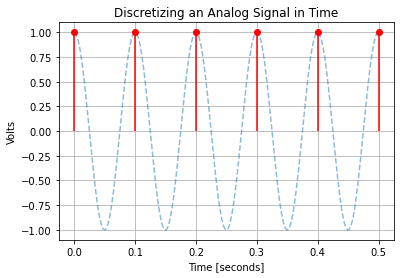

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from math import floor

%matplotlib inline

def plot_samples_on_signal(signal, *, duration, sampling_rate):
    fig, ax = plt.subplots()

    # we densely sample the analog signal to make it look like
    # it is continuous
    dense_t = np.linspace(0, duration, 10000)  # seconds
    ax.plot(dense_t, signal(dense_t), ls="--", label="Analog Signal", alpha=0.5)

    times, samples = temporal_sampler(signal=signal, duration=duration, sampling_rate=sampling_rate)

    # creates the stem plot indicating our samples
    ax.stem(
        times,
        samples,
        "red",
        markerfmt="ro",
        basefmt=" ",
        label="samples",
        use_line_collection=True
    )
    ax.set_xlabel("Time [seconds]")
    ax.set_ylabel("Volts")
    ax.set_title("Discretizing an Analog Signal in Time")
    ax.grid(True)
    return fig, ax


def f(t):
    freq = 10 # Hz
    return np.cos(2 * np.pi * freq * t)

fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=10)

Now, re-sample the signal at with the sampling rate doubled and plot the results. Do these samples do a better job of representing our signal?

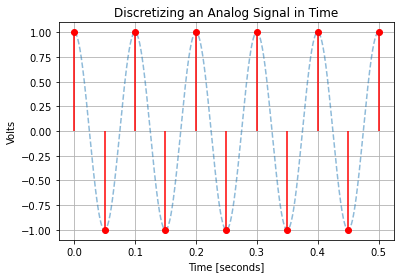

In [7]:
fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=20.)


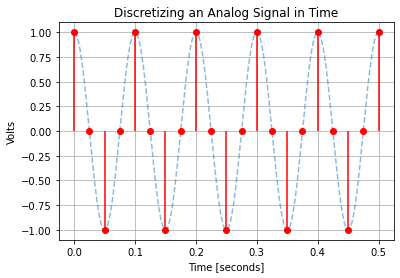

In [8]:
fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=40.)


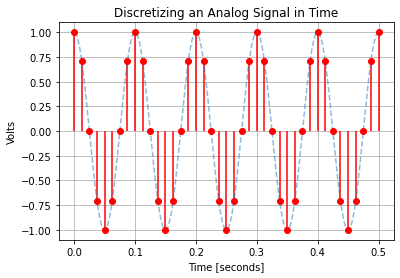

In [9]:
fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=80.)


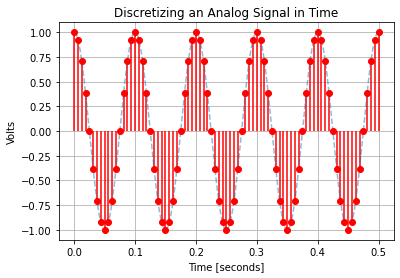

In [10]:
fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=160.)


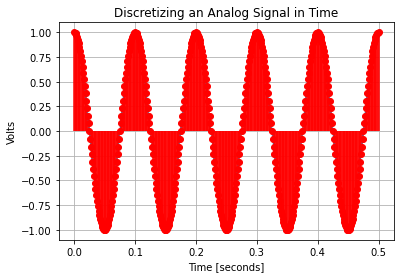

In [12]:
fig, ax = plot_samples_on_signal(signal=f, duration=0.5, sampling_rate=800.)


This doubling between the highest frequency of an analog signal and the minimum viable sampling rate needed to discretize it "faithfully" has a special name: this sampling rate is known as the "Nyquist rate", as prescribed by the [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). In general, one needs to use a sampling rate that exceeds the Nyquist rate (twice the highest-frequency component of the analog signal) in order to be able to faithfully reconstruct the analog signal from the samples.

Reflecting on this, and given that we humans can perceive tones with frequencies up to roughly 20,000 Hz, why might the audio industry use a sampling rate of 44,100 Hz

for digitizing audio signals?

(Aside: If you have ever tweaked an “anti-aliasing” parameter in a video game’s settings, this is to help prevent aliasing in the spatially-sampled illumination values that will be displayed on your screen, which can cause undesirable pixelation effects.)

### Bit Depth
https://rsokl.github.io/CogWeb/Audio/digitizing_signals.html#Bit-Depth

We just reviewed the process of discretizing our analog signal in time by establishing a temporal sampling rate. Now we will discretize the magnitudes of the values that we record from out voltmeter; we will do this by establishing a bit-depth for our digitization process. This will, in effect, decide the number of “significant digits” that we use to record our measurements.



#### Quantization

Write a python function called `quantize`, which performs the quantization process discussed above. Read the docstring for the function “stub” provided below. Note that you need not convert the quantized values to sequences of binary digits.

In [5]:
def quantize(samples, bit_depth):
    """
    Given an array of N samples and a bit-depth of M, return the array of
    quantized samples derived from the domain [samples.min(), samples.max()]
    that has been quantized into 2**M evenly-spaced values.

    Parameters
    ----------
    samples : numpy.ndarray, shape-(N,)
        An array of N samples

    bit_depth: int
        The bit-depth, M, used to quantize the samples among
        2**M evenly spaced values spanning [samples.min(), samples.max()]

    Returns
    -------
    quantized_samples : numpy.ndarray, shape-(N,)
        The corresponding array where each sample has been replaced
        by the nearest quantized value

    Examples
    --------
    >>> import numpy as np
    >>> samples = np.array([0, .25, .75, 1])
    >>> quantize(samples, 1) # bit-depth 1: quantize among 2**1 values
    array([0., 0., 1., 1.])
    >>> quantize(samples, 2) # bit-depth 2: quantize among 2**2 values
    array([0., 0.3333, .6666, 1.])
    """
    # include this line of code to prevent yourself from
    # trying such a large bit-depth that your computer
    # becomes overburdened
    assert bit_depth <= 14, "Exceeding this bit-depth might tank your computer!"

    # STUDENT CODE

    # create the 2**M evenly-spaced quantized values,
    # spanning [samples.min(), samples.max()]
    quantized_values = np.linspace(samples.min(), samples.max(), 2 ** bit_depth)

    # Broadcast subtract: shape-(N, 1) w/ shape-(M**2,) -> shape(N, M**2)
    # `abs_differences[i]` is the absolute difference between sample-i and
    # each of the M**2 quantized values
    abs_differences = np.abs(samples[:, np.newaxis] - quantized_values)

    # For each sample, find which quantized value it is closest to.
    # Produced shape-(N,) array on indices on [0, 2**M)
    bin_lookup = np.argmin(abs_differences, axis=1)

    # Populate a shape-(N,) array, where each sample has been
    # replaced by its nearest quantized value. This leverages
    # advanced integer-array indexing
    return quantized_values[bin_lookup]
    
    

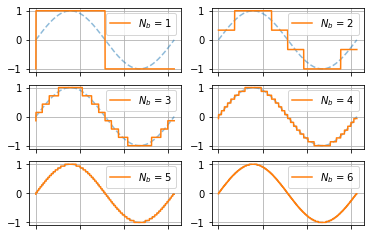

In [15]:
# Quantize Sine

fig, axes = plt.subplots(ncols=2, nrows=3)
t = np.linspace(0, 2 * np.pi, 1000)

for n, ax in enumerate(axes.ravel()):
    ax.plot(t, np.sin(t), ls="--", alpha=0.5)
    ax.plot(t, quantize(np.sin(t), n + 1), label=r"$N_b$ = {}".format(n + 1))
    ax.grid(True)
    ax.legend()
    ax.xaxis.set_ticklabels([])
    

Find an mp3 file on your computer or device, and check to see how long the song is. Based on this number, and using the standard PCM encoding parameters:

 * f<sub>s</sub> = 44,100 Hz
 * N<sub>d</sub> = 16 bits

compute how large you would expect this digital audio file to be, had it been written using PCM encoding, to the nearest tenth of a megabyte. Compare this to the actual size of the file on your computer. You should see that the size of mp3 file is considerably smaller than your calculated PCM file. This is because the mp3 format is a compressed audio format that can reduce the memory footprint of a recording by, among other things, filtering out data that would be imperceivable to the listener.

Using a four minute song as a reference, we would expect a PCM-encoded digital audio file, using a bit-depth of 16 bits and a sampling rate of 44.1kHz to take up:
    
\begin{equation}4 \;\mathrm{minutes}\times 60\;\frac{\mathrm{seconds}}{\mathrm{minute}}\times 44,100\;\frac{\mathrm{samples}}{\mathrm{second}}
 \times 16\;\frac{\mathrm{bits}}{\mathrm{sample}} \times \;\frac{1\; \mathrm{megabytes}}{2\times10^6\;\mathrm{bits}} = 21.2\; \mathrm{megabytes}
 \end{equation}

In [22]:
songlength = 4   #minutes
samplingrate = 44100  #samples/sec
bits_per_sample = 16

expected_size = songlength * 60 * samplingrate * bits_per_sample / (2 * pow(10, 6))
expected_size

84.672

Study the PCM sampling process depicted here:  

![Image of sampling](https://rsokl.github.io/CogWeb/_images/fs_2_Nb_3.png)

What is the temporal sampling rate and apparent bit-depth used here?

 * The figure shows that four samples fit squarely within each 2-second interval on the plot, thus a temporal sampling rate of 2 Hz was used ( $ \frac{4 \;\mathrm{samples}} {2 \;\mathrm{seconds}} = 2 \;\mathrm{Hz}\  $ ).

 * Furthermore, the voltmeter measurements are binned into 8 quantized values, thus a bit-depth of $ N_b = \log_2{8} = 3 $ was used. 


Study the code below for reproducing the figures from this chapter. 

__Experiment with it and see how you can affect the plot.__


<IPython.core.display.Javascript object>


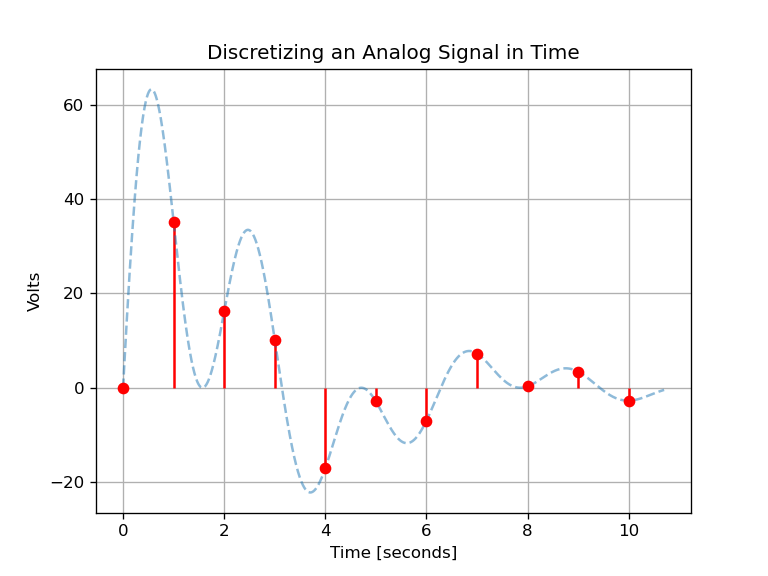

In [6]:
from math import floor

# defining the "analog signal"
def f(t):
    return np.sin(2 * t) * np.cos(t) * np.exp(-t / 3) * 100


def temporal_sampler(signal, *, duration, sampling_rate):
    """
    Extracts samples from an analog signal according to the
    specified sampling rate, returning the times and the
    corresponding samples
    """
    N_samples = floor(sampling_rate * duration) + 1
    times = np.arange(N_samples) * (1 / sampling_rate)  # seconds
    samples = signal(times)
    return times, samples

def plot_samples_on_signal(signal, *, duration, sampling_rate):
    fig, ax = plt.subplots()

    # we densely sample the analog signal to make it look like
    # it is continuous
    dense_t = np.linspace(0, duration, 10000)  # seconds
    ax.plot(dense_t, signal(dense_t), ls="--", label="Analog Signal", alpha=0.5)

    times, samples = temporal_sampler(signal=signal, duration=duration, sampling_rate=sampling_rate)

    # creates the stem plot indicating our samples
    ax.stem(
        times,
        samples,
        "red",
        markerfmt="ro",
        basefmt=" ",
        label="samples",
        use_line_collection=True
    )
    ax.set_xlabel("Time [seconds]")
    ax.set_ylabel("Volts")
    ax.set_title("Discretizing an Analog Signal in Time")
    ax.grid(True)
    return fig, ax


plot_samples_on_signal(f, duration=10.7, sampling_rate=1);